### Load the Data 

In [194]:
!pip3 install matplotlib seaborn scikit-learn

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

file_path = 'googleplaystore.csv'
data = pd.read_csv(file_path)

### Check for Null Values

In [196]:
null_values = data.isnull().sum()
print(null_values)

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


### Drop Records with Nulls

In [197]:
data.dropna(inplace=True)

### Data Type Correction and Formatting

In [198]:
# Handling the 'Size' column
def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', '')) * 1000
    elif 'k' in size:
        return float(size.replace('k', ''))
    else:
        return None
    
data['Size'] = data['Size'].map(convert_size)

# Convert 'Reviews' to numeric
data['Reviews'] = pd.to_numeric(data['Reviews'])

# Clean 'Installs' and convert to integer
data['Installs'] = data['Installs'].str.replace('+', '').str.replace(',', '').astype(int)

# Remove '$' from 'Price' and convert to numeric
data['Price'] = data['Price'].str.replace('$', '').astype(float)

# Outlier Treatment for Price
# Remove apps with a price over $200
data = data[data['Price'] < 200]

# Outlier Treatment for Reviews
# Remove apps with more than 2 million reviews
data = data[data['Reviews'] <= 2000000]

# Calculating percentiles for Installs
percentiles = data['Installs'].quantile([0.1, 0.25, 0.5, 0.7, 0.9, 0.95, 0.99]).to_dict()
print("Percentiles for Installs:")
print(percentiles)

# Decide on a threshold for Installs to remove outliers
# For example, using the 95th percentile as the cutoff
threshold = percentiles[0.95]
data = data[data['Installs'] <= threshold]



Percentiles for Installs:
{0.1: 1000.0, 0.25: 10000.0, 0.5: 500000.0, 0.7: 1000000.0, 0.9: 10000000.0, 0.95: 10000000.0, 0.99: 100000000.0}


### Set the esthetic style of the plots 

In [199]:
sns.set_style('whitegrid')

### Boxplot for Price

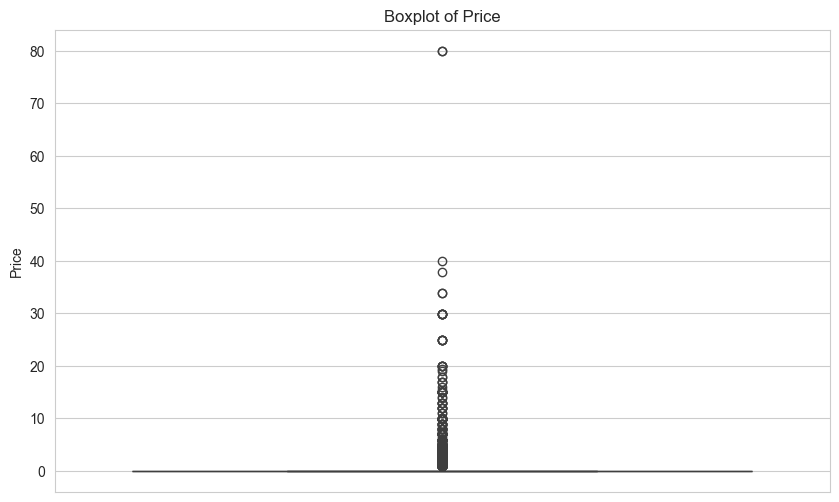

In [200]:
plt.figure(figsize=(10, 6))
sns.boxplot(data['Price'])
plt.title('Boxplot of Price')
plt.show()

### Boxplot for Reviews

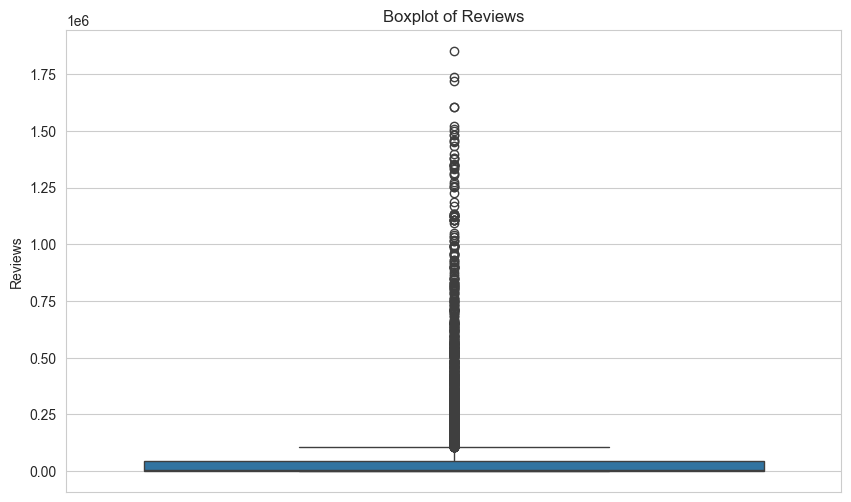

In [201]:
plt.figure(figsize=(10, 6))
sns.boxplot(data['Reviews'])
plt.title('Boxplot of Reviews')
plt.show()

### Histogram for Rating

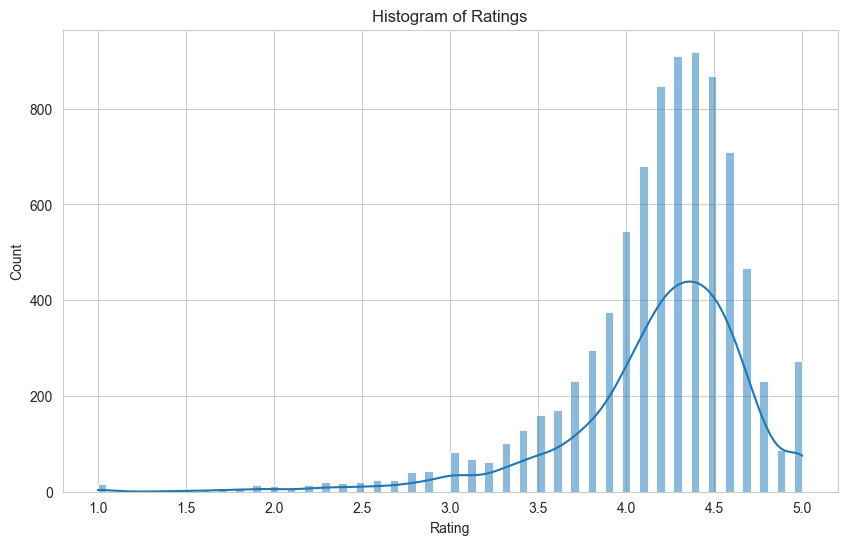

In [202]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Rating'], kde=True)
plt.title('Histogram of Ratings')
plt.show()

### Histogram for Size

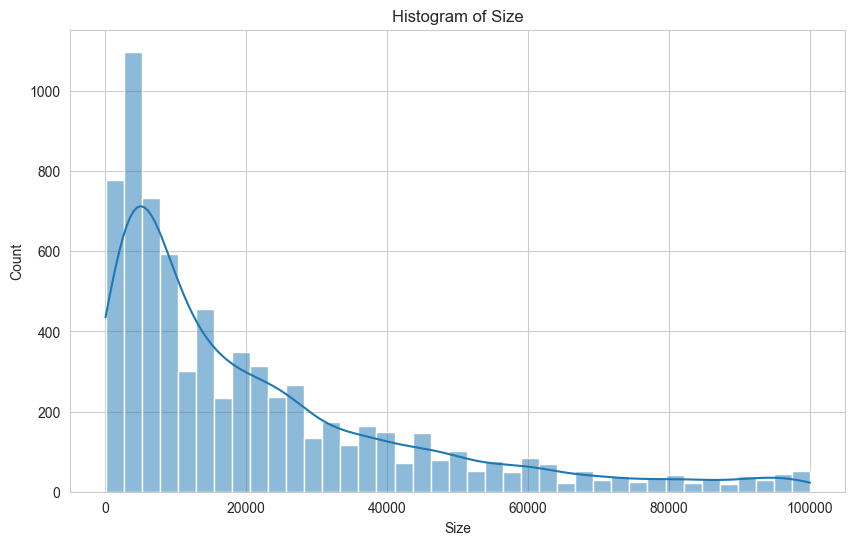

In [203]:
plt.figure(figsize=(10, 6))
sns.histplot(data[data['Size'].notnull()]['Size'], kde=True)  # Excluding null values in Size for histogram
plt.title('Histogram of Size')
plt.show()

### Observation Notes
Boxplot for price has a couple outliers around 100 and 300. 
Boxplot for review has no visible outliers.
Histogram for rating has one outlier at 1.0. It also seems the most reviews were given to higher ratings between 4.0 and 4.5. H
Histogram for size has no outliers. 

### Scatterplot for Rating vs. Price 

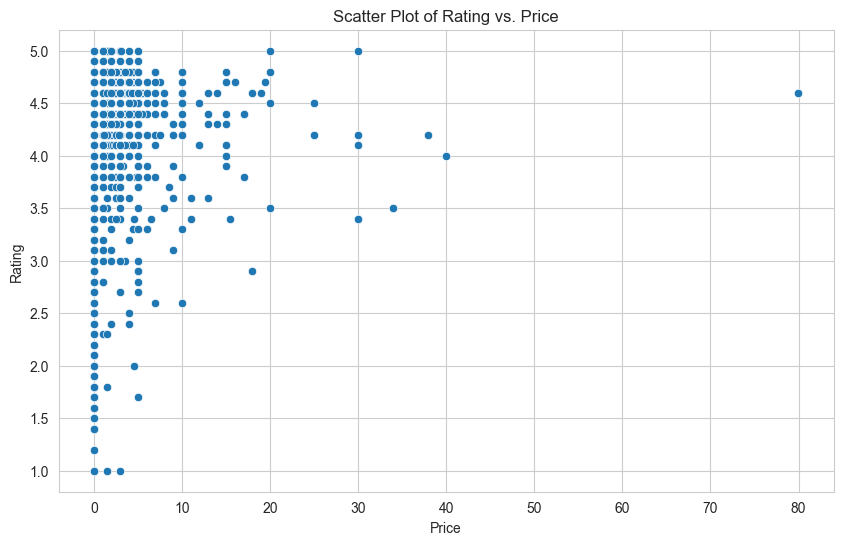

In [204]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Price'], y=data['Rating'])
plt.title('Scatter Plot of Rating vs. Price')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()

### Scatterplot for Rating vs. Size

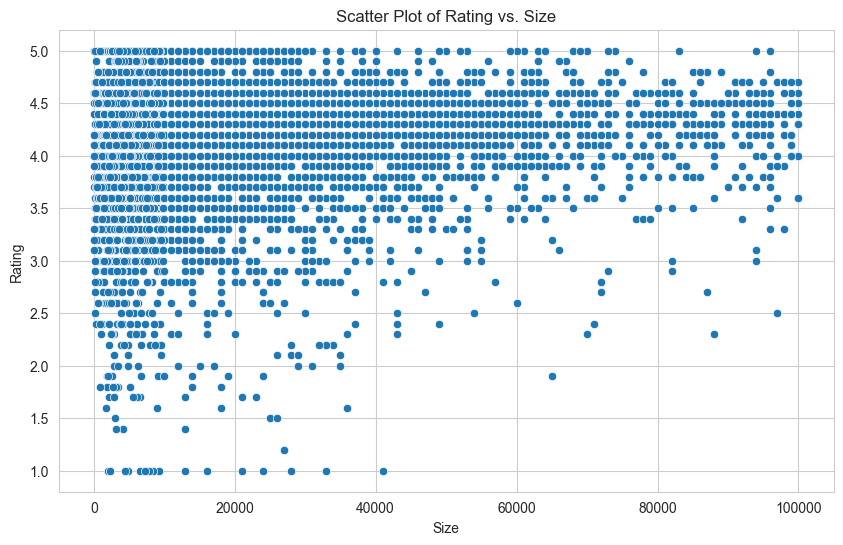

In [205]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Size'], y=data['Rating'])
plt.title('Scatter Plot of Rating vs. Size')
plt.xlabel('Size')
plt.ylabel('Rating')
plt.show()

### Scatterplot for Rating vs. Reviews

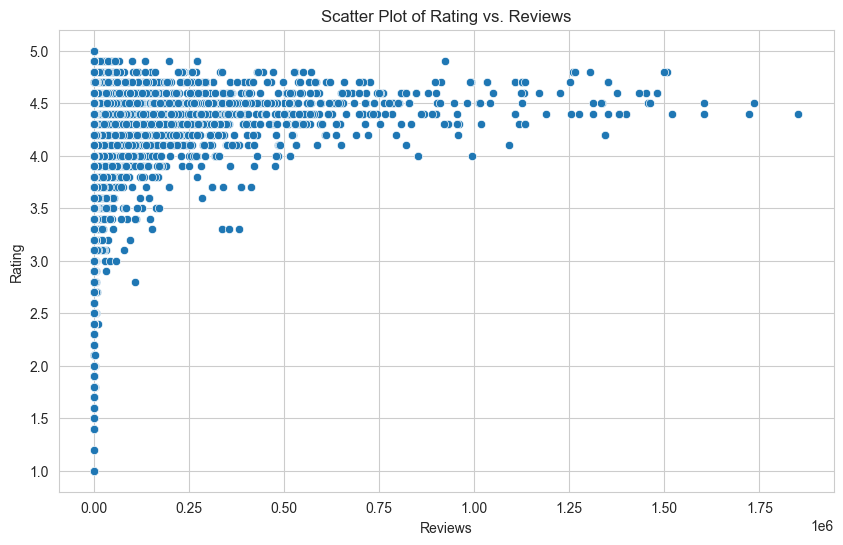

In [206]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Reviews'], y=data['Rating'])
plt.title('Scatter Plot of Rating vs. Reviews')
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.show()

### Boxplot for Rating vs. Content Rating

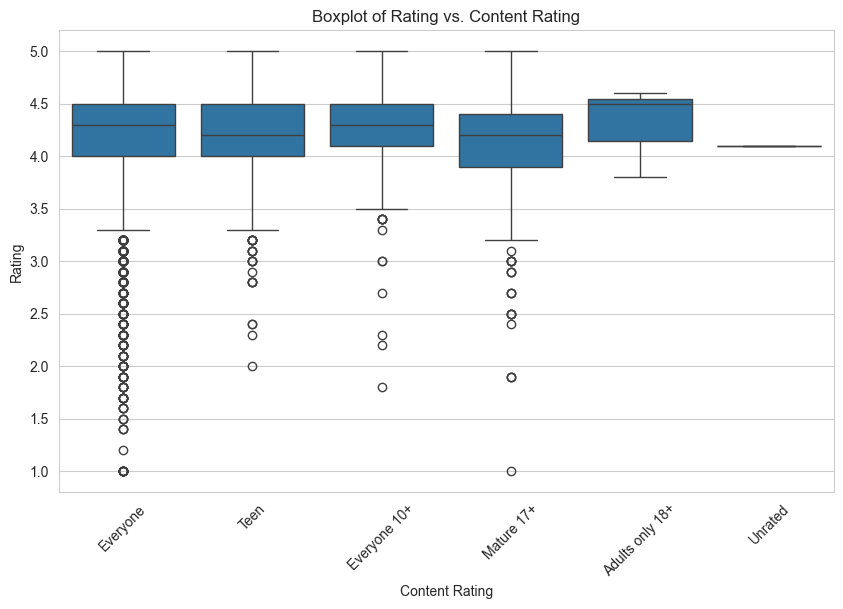

In [207]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Content Rating'], y=data['Rating'])
plt.title('Boxplot of Rating vs. Content Rating')
plt.xlabel('Content Rating')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()

### Boxplot for Ratings vs. Category 

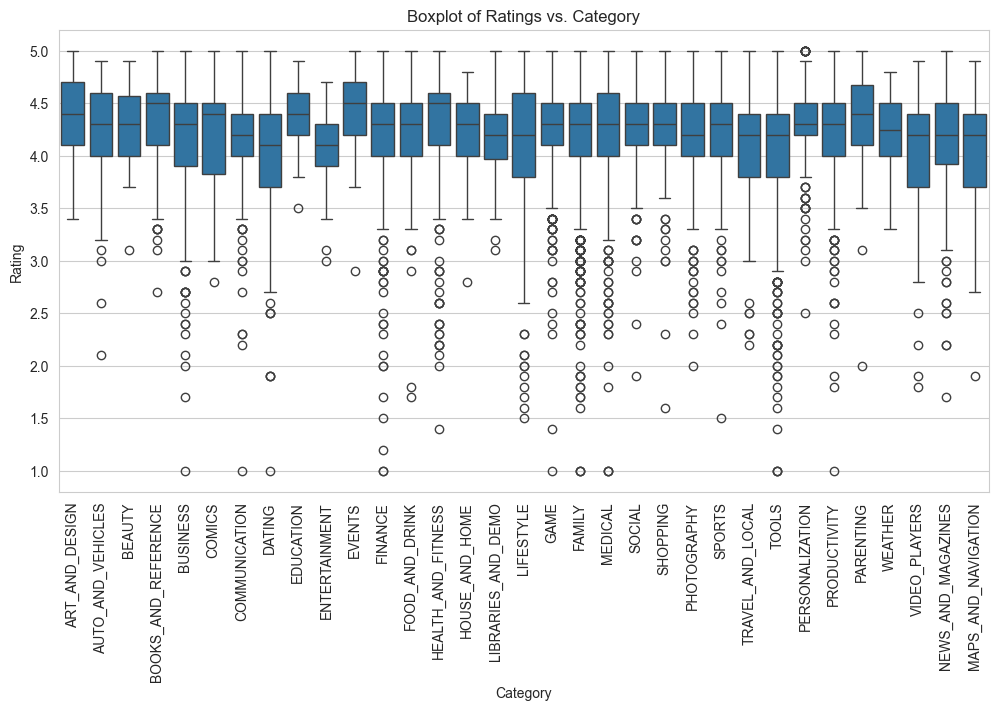

In [208]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['Category'], y=data['Rating'])
plt.title('Boxplot of Ratings vs. Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.show()

### Create a Copy of the DataFrame

In [209]:
inp1 = data.copy()

### Log Transformation  

In [210]:
inp1['Reviews'] = np.log1p(inp1['Reviews'])
inp1['Installs'] = np.log1p(inp1['Installs'])

### Drop Unnecessary Columns

In [211]:
data.drop(['App', 'Last Updated', 'Current Ver', 'Android Ver', 'Size'], axis=1, inplace=True)


### Dummy Encoding

In [212]:
inp1 = pd.get_dummies(inp1, columns=['Category', 'Type', 'Content Rating', 'Genres'], drop_first=True)


### Train-Test-Split (70-30 Split)

In [213]:
df_train, df_test = train_test_split(inp1, test_size=0.3, random_state=42)


### Separate into X_train, y_train, X_test, and y_test

In [214]:
X_train = df_train.drop('Rating', axis=1)
y_train = df_train['Rating']
X_test = df_test.drop('Rating', axis=1)
y_test = df_test['Rating']

In [215]:
# Separate numeric and non-numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns

# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to only the numeric columns
X_train_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_train[numeric_cols]), columns=numeric_cols)

# Combine imputed numeric columns with non-numeric columns
X_train_imputed = pd.concat([X_train_numeric_imputed, X_train[non_numeric_cols].reset_index(drop=True)], axis=1)

X_train_encoded = pd.get_dummies(X_train_imputed, columns=non_numeric_cols)


### Model Building and Reporting R2 Score

In [216]:
# Building the model
model = LinearRegression()
model.fit(X_train_encoded, y_train)

# Predicting and calculating R2 Score
y_train_pred = model.predict(X_train_encoded)
r2_train = r2_score(y_train, y_train_pred)

print(f"R2 Score on the Train Set: {r2_train}")



R2 Score on the Train Set: 0.999994431238104
